In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score

# Using Linear Regression and CAPM to predict stock market return

## Abstract

The task of predicting stock market prices based on previously known historical data, is a subject of multiple researches over the years. The task is complex because there are multiple factors which can affect the stock market like: political factors, wars, recession, balloons. The most crucial and unpredictable factor is the human behaviour of the individual investors. This lab is aiming to compare two very common methods for stock market prediction, based on pure statistics - Linear Regression and Capital Asset Pricing Model (CAPM).

## Datasets

There are two distinctive types of stock market information available based on the type of trading: intraday and historic. During intraday trading every stock transaction is recorded on a minute basis, while the historic data is recorded on a daily basis. We are going to use the second one. It represents a time series record which contains one record per stock on a daily basis. Every stock record contains the following elements:
  * Date - the date
  * Open - the stock price during opening of the market
  * High - the highest stock price of the current day
  * Low - the lowest stock price of the current day
  * Close - the price during the market close
  * Adj Close - same as Close, but it takes into account dividends yield and stock splits
  * Volume - the amount of stock sold in the current day
 
Also every stock is identified by a unique ticker code which identifies a listed company e.g. AAPL(Apple), MSFT(Microsoft). In our dataset the ticker is used for a filename and the upper features are available in every row. They summarise all stock trades which have happened for a single day. The second data set which we use is special and it is available in a file called `DGS10.csv`. It represents  "Market Yield on U.S. Treasury Securities at 10-Year Constant Maturity, Quoted on an Investment Basis". Behind this strange name, we actually have two features:
* Date a - date
* Interest rate in percent
It contains is on a daily basis as well and we are going to use it during capm calculation. More details later.

## Reding historic data for a given stock

Since we are going to read stock data for several stocks, and each stock data is stored in a separate file, I will use the following function to read the stock data frame and convert its fields to more suitable formats:

In [2]:
def load_stock(ticker):
    """Reads historic stock data and loads it in a data frame
           ticker - the stock ticker
    """
    ticker = ticker.upper()
    df = pd.read_csv(f"data/{ticker}.csv")
    df.columns=["date","open","high","low","close","adj close","vol"]
    df["ticker"] = ticker
    df["date"] = pd.to_datetime(df["date"])
    return df

Now lets read the historic data of one of the most well known industrial indexes SP500

In [3]:
sp500 = load_stock("sp500")

In [4]:
sp500

,date,open,high,low,close,adj close,vol,ticker
0,2013-08-26,1664.290039,1669.510010,1656.020020,1656.780029,1656.780029,2430670000,SP500
1,2013-08-27,1652.540039,1652.540039,1629.050049,1630.479980,1630.479980,3219190000,SP500
2,2013-08-28,1630.250000,1641.180054,1627.469971,1634.959961,1634.959961,2784010000,SP500
3,2013-08-29,1633.500000,1646.410034,1630.880005,1638.170044,1638.170044,2527550000,SP500
4,2013-08-30,1638.890015,1640.079956,1628.050049,1632.969971,1632.969971,2734300000,SP500
...,...,...,...,...,...,...,...,...
2509,2023-08-15,4478.870117,4478.870117,4432.189941,4437.859863,4437.859863,3832250000,SP500
2510,2023-08-16,4433.790039,4449.950195,4403.549805,4404.330078,4404.330078,3753910000,SP500
2511,2023-08-17,4416.319824,4421.169922,4364.830078,4370.359863,4370.359863,3943700000,SP500
2512,2023-08-18,4344.879883,4381.819824,4335.310059,4369.709961,4369.709961,3940400000,SP500


In [5]:
sp500.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2514 entries, 0 to 2513
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       2514 non-null   datetime64[ns]
 1   open       2514 non-null   float64       
 2   high       2514 non-null   float64       
 3   low        2514 non-null   float64       
 4   close      2514 non-null   float64       
 5   adj close  2514 non-null   float64       
 6   vol        2514 non-null   int64         
 7   ticker     2514 non-null   object        
dtypes: datetime64[ns](1), float64(5), int64(1), object(1)
memory usage: 157.2+ KB


Now lets read two more stocks and plot their charts, from all prices available we are going to use `Adj Close` to identify the daily price of a stock.

In [6]:
msft = load_stock("MSFT") # Microsoft
aapl = load_stock("AAPL") # Apple

Now lets plot the SP500 index and the two stock on the same chart. Since we may need to plot stock charts multiple times the following function is created:

In [7]:
def plot_stocks(*stocks, close_price_col = "adj close"):
    """Plots several stocks in a same chart"""
    tickers = []
    for stock in stocks:            
        tickers.append(stock.iloc[0].ticker)
        x = stock["date"]
        y = stock[close_price_col]
        plt.plot(x,y)
    
    plt.gca().set(title=f"{','.join(tickers)} - Historic", xlabel="date", ylabel="price")
    plt.legend(tickers)
    plt.show()

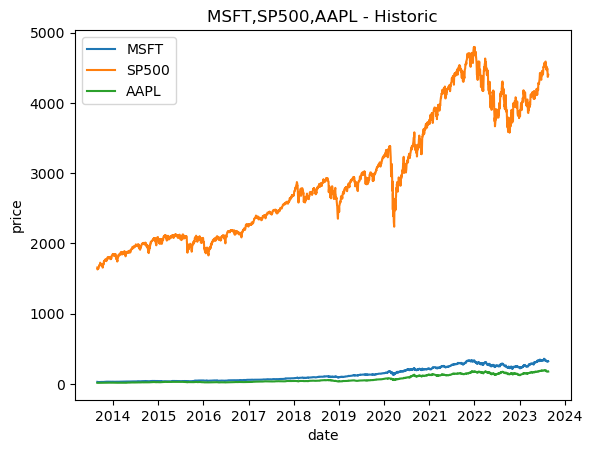

In [8]:
plot_stocks(msft, sp500, aapl)

As you can see SP500 is far more expensive because it is an index and it consists of multiple stocks. We are going to use it as a market benchmark, because it follows multiple companies and will give us a more accurate view of current market state.

## Calculating return of a stock

Before we continue, we need to introduce some definitiions: 
* Price of a stock - The Price of a stock is what you pay to buy / sell the asset in the market
* Stock return - Return refers to the amount of money you make from your investment, expressed in % terms

To be able to calculate the stock return we use the following formula:
$$
 r = \frac{P_{t + 1} - P_{t}}{P_{t}} = \frac{P_{t + 1}}{P_{t}} - 1
$$

Where: 

$P_{t + 1}$ - Serlling price, 

$P_{t}$ - Purchase price,   

$r$ - Return

We have created a function which is going to add the daily returns for a dataset:

In [9]:
def add_daily_returns(df, close_price_col = "adj close"):
    """Calculates a daily return of a stock"""
    df["daily returns"] =  df[close_price_col].pct_change(1)    
    return df.dropna()

In [10]:
msft = add_daily_returns(msft)
sp500 = add_daily_returns(sp500)
aapl = add_daily_returns(aapl)

In [11]:
msft

,date,open,high,low,close,adj close,vol,ticker,daily returns
1,2013-08-27,33.520000,34.099998,33.150002,33.259998,27.852409,58522300,MSFT,-0.026062
2,2013-08-28,33.389999,33.599998,33.000000,33.020000,27.651442,44257400,MSFT,-0.007215
3,2013-08-29,32.930000,33.599998,32.799999,33.549999,28.095263,45284700,MSFT,0.016051
4,2013-08-30,33.369999,33.480000,33.090000,33.400002,27.969656,42790200,MSFT,-0.004471
5,2013-09-03,31.750000,32.070000,31.290001,31.879999,26.696783,154507000,MSFT,-0.045509
...,...,...,...,...,...,...,...,...,...
2509,2023-08-15,323.000000,325.089996,320.899994,321.859985,321.179962,16966300,MSFT,-0.006728
2510,2023-08-16,320.799988,324.420013,319.799988,320.399994,320.399994,20698900,MSFT,-0.002428
2511,2023-08-17,320.540009,321.869995,316.209991,316.880005,316.880005,21257200,MSFT,-0.010986
2512,2023-08-18,314.489990,318.380005,311.549988,316.480011,316.480011,24744800,MSFT,-0.001262


We can plot a stock market return:

In [12]:
def plot_returns(df):
    x = df["date"]
    y = df["daily returns"]
    ticker = df.iloc[0].ticker
    plt.plot(x,y)
    plt.xticks(rotation=70)
    plt.gca().set(title=f"{ticker} - Daily Returns", xlabel="date", ylabel="Returns[%]")
    plt.show()

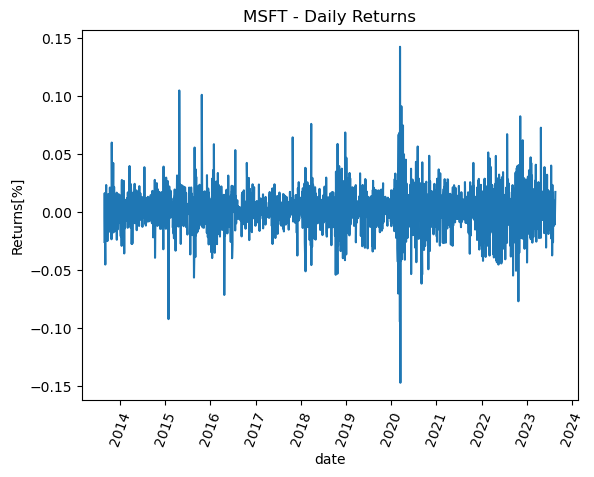

In [13]:
plot_returns(msft)

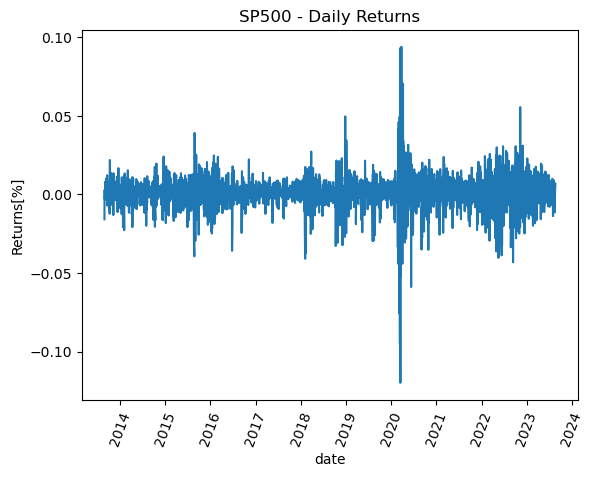

In [14]:
plot_returns(sp500)

## Predicting stock price using Linear Regression and SP500 as benchmark

As we mentined we need to know how a given stock is going to move if we have some historic insights about the market. A good benchmark is SP500 because it consists 500 companies from different sectors. Indexes are used as benchmark becuase they eliminate company specific or sector specific market behaviour.

Lests scatter plot SP500 and MSFT daily returns:

In [15]:
sp500_daily_returns = sp500["daily returns"] 
msft_daily_returns = msft["daily returns"] 
apple_daily_returns = aapl["daily returns"] 

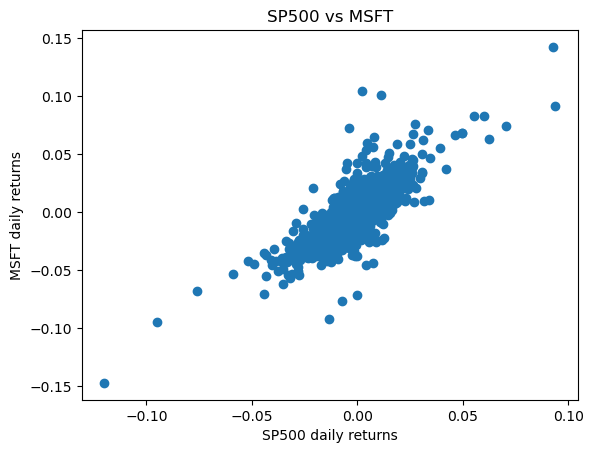

In [16]:
plt.scatter(sp500_daily_returns, msft_daily_returns)
plt.title("SP500 vs MSFT")
plt.xlabel("SP500 daily returns")
plt.ylabel("MSFT daily returns")
plt.show()

To some extent we expect that a stock mimics the behaviour of the market on a global level. During a recession on a decreasing market it is not uncommon a stock to be underpriced and in icontrary, during boom, it is not uncommon a stock to be overpriced.

### Using linear regression

Since we are going to need to train a regression model for every given stock a function is created:

In [17]:
def predic_returns(target_df, benchmark_df, test_size = 0.15):
    
    train_x, test_x, train_y, test_y = train_test_split(benchmark_df, target_df, test_size=test_size , shuffle=False,random_state = 0)
    
    regression = LinearRegression()
    regression.fit(train_x.values.reshape(-1,1), train_y)
    predicted_returns = regression.predict(test_x.values.reshape(-1,1))
    
    return (predicted_returns, regression, test_y)

A train test split is used, but without any shuffle since the stock data represents time series. The last 15% of the data frame is used as test data. This is quite convenient since we usually try to predict the place on date  X+1 when  the current date is X using all currently known data till date X. So in our case the train split is the historical data while the test split is actually the actual stock behaviour.

A helper function is created as well so we can print most of the regression statistics:

In [18]:
def print_regression_stats(predicted_returns, regression, actual_returns):
    print("Mean Absolute Error (MAE):", mean_absolute_error(actual_returns, predicted_returns))
    print("Mean Squared Error (MSE) :", mean_squared_error(actual_returns, predicted_returns))
    print("Root Mean Squared Error (RMSE):", np.sqrt(mean_squared_error(actual_returns, predicted_returns)))    
    print("Root Mean Squared Error (RMSE):", np.sqrt(mean_squared_error(actual_returns, predicted_returns)))
    print("Regression coef (Beta):", regression.coef_)
    print("Intercept (Alpha):", regression.intercept_)
    print("Score:", regression.score(predicted_returns.reshape(-1, 1), actual_returns))
    print("R^2 Score:", r2_score(actual_returns, predicted_returns))

### Predicting Microsoft Price

In [19]:
msft_predicted_returns, regression, msft_actual_returns = predic_returns(msft_daily_returns, sp500_daily_returns)

In [20]:
print_regression_stats(msft_predicted_returns, regression, msft_actual_returns)

Mean Absolute Error (MAE): 0.00824054029697089
Mean Squared Error (MSE) : 0.00014137362616771713
Root Mean Squared Error (RMSE): 0.011890064178452408
Root Mean Squared Error (RMSE): 0.011890064178452408
Regression coef (Beta): [1.1876018]
Intercept (Alpha): 0.0006043745081000471
Score: 0.6608801828511824
R^2 Score: 0.665388184771174


Following the regression metrics our current model is around 66% accurate. Now lets compare and plot actuall returns vs predicted returns.

In [21]:
dates = msft.loc[msft_actual_returns.index]["date"]
msft_returns_comparision = pd.DataFrame({"date": dates, "actual returns":msft_actual_returns, "predicted returns":msft_predicted_returns})

In [22]:
msft_returns_comparision

,date,actual returns,predicted returns
2137,2022-02-18,-0.009631,-0.007906
2138,2022-02-22,-0.000729,-0.011441
2139,2022-02-23,-0.025893,-0.021262
2140,2022-02-24,0.051094,0.018367
2141,2022-02-25,0.009233,0.027174
...,...,...,...
2509,2023-08-15,-0.006728,-0.013114
2510,2023-08-16,-0.002428,-0.008368
2511,2023-08-17,-0.010986,-0.008555
2512,2023-08-18,-0.001262,0.000428


In [23]:
x = msft_returns_comparision["date"]
y1 = msft_returns_comparision["actual returns"]
y2 = msft_returns_comparision["predicted returns"]

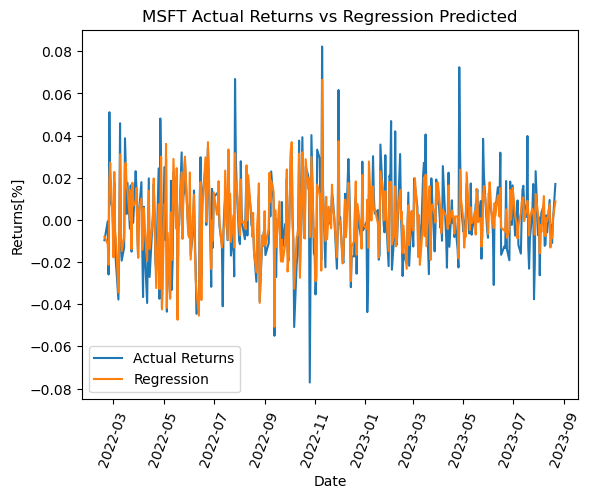

In [24]:
plt.plot(x, y1)
plt.plot(x, y2)
plt.xticks(rotation=70)
plt.title("MSFT Actual Returns vs Regression Predicted")
plt.legend(["Actual Returns", "Regression"])
plt.xlabel("Date")
plt.ylabel("Returns[%]")
plt.show()

### Predicting Apple Price

In [25]:
apple_predicted_returns, regression, apple_actual_returns = predic_returns(apple_daily_returns, sp500_daily_returns)

In [26]:
print_regression_stats(apple_predicted_returns, regression, apple_actual_returns)

Mean Absolute Error (MAE): 0.007203623097589115
Mean Squared Error (MSE) : 0.00010122362746586741
Root Mean Squared Error (RMSE): 0.010060995351647242
Root Mean Squared Error (RMSE): 0.010060995351647242
Regression coef (Beta): [1.15799534]
Intercept (Alpha): 0.0006709867670068737
Score: 0.7354002162438933
R^2 Score: 0.733580331966668


As we can see in the case of apple, the model accuracy is around 73% which is better

## Predicting stock price using CAPM

Asset Pricing Models are tools that use math and logic to determine the expected return of financial securities. Actually the regression we used is a form of **generalized asset pricing model**. It can be described with the following formula:


$$
E[r_{jt}] = \alpha + \beta_{j}F_{t} + \epsilon_{t}
$$
Where:

$E[r_{jt}]$ - is expected rturn of a stock $j$ a time $t$

$F_{t}$ - is factor that impacts the expected return of $j$ a at time $t$, in our case the market return

$\beta_{j}$ - Slope (impact on $E[r_{j}]$) when $F$ changes (Also called market risk or systematic risk)

$\epsilon_{t}$ - Error term

**The Capital Asset Pricing Model** (CAPM) is one of the most pricing models. It is so called two factor model. The CAPM works on the premise that the return on any asset is based exclusivelyon the asset’s relationship with the market. It can be described with the following formula:

$$
E[r_{jt}] = r_{f} + \beta_{j}(E[r_{m}] - r_{f})
$$

Where:
$E[r_{jt}]$ - is expected rturn of a stock $j$ a time $t$

$E[r_{m}]$ - is expected return on the market

$r_{f}$ - Risk free rate (e.g. Yield of T-bills or T-bonds)

$\beta_{j}$ - Systematic risk (market risk) of stock $j$

As a two factor model the CAPM is expected to be more accurate than Linear Regression because it adds one additional factor, the interest rate. Let's define that as our hypothesis:
**We expect CAPM to predict stock prices more accurate than simple Linear Regression**

### Loading T-Bonds interest rate data set

For calculating the risk free rate of the CAPM model, usually it is used the interest rate on US treasury bonds. Why considered risk free. It is likely  uncommon for the US Government to stop paying the interest rate on its government bonds. To simplify the loading process a separed function is created:

In [27]:
def load_bond_interest_rates(data_file = "DGS10.csv"):
    """Reads the T-Bond interest rates"""
    
    def replace_null_interest_rate(df, null_id = "."):
    
        corrupted = df[df["interest rate"] == null_id]

        for index in corrupted.index:

            current = df.iloc[corrupted.index]

            while current["interest rate"].values[0] == null_id:
                current = df.iloc[current.index - 1]

            df.loc[index, "interest rate"] = current["interest rate"].values[0]

        return df
    
    bond_interest_rates = pd.read_csv(f"data/{data_file}")
    bond_interest_rates.columns = ["date", "interest rate"]
    bond_interest_rates["date"] = pd.to_datetime(bond_interest_rates["date"])
    bond_interest_rates = replace_null_interest_rate(bond_interest_rates)
    bond_interest_rates["interest rate"] = pd.to_numeric(bond_interest_rates["interest rate"])
    bond_interest_rates["interest rate"] = bond_interest_rates["interest rate"] / 100
    return bond_interest_rates

As we can see there is an inner function which we use because some of the interest rates are empty. The data cleaning strategy which we implemented is to replace the "," with the interest rate from the previous day, which is relatively accurate.

In [28]:
bond_interest_rates = load_bond_interest_rates()

In [29]:
bond_interest_rates.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1305 entries, 0 to 1304
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           1305 non-null   datetime64[ns]
 1   interest rate  1305 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 20.5 KB


In [30]:
bond_interest_rates

,date,interest rate
0,2018-08-21,0.0285
1,2018-08-22,0.0282
2,2018-08-23,0.0282
3,2018-08-24,0.0282
4,2018-08-27,0.0285
...,...,...
1300,2023-08-15,0.0421
1301,2023-08-16,0.0428
1302,2023-08-17,0.0430
1303,2023-08-18,0.0426


### Predict Apple stocks using CAPM

For predicting stock returns using CAPM the following function was ceated.

In [31]:
def predict_returns_capm(target_ticker, beta, benchmark_df, bond_interest_rates):
    """Predicts daily returns using CAPM"""
    capm_returns_df = benchmark_df.merge(bond_interest_rates, on = "date")
    capm_returns_df["target ticker"] = target_ticker
    capm_returns_df["beta"] = beta[0]
    capm_returns_df.rename(columns = { "ticker" : "benchmark ticker"}, inplace=True)
    capm_returns_df["capm predicted returns"] = capm_returns_df["interest rate"] + beta * (capm_returns_df["daily returns"] - capm_returns_df["interest rate"])
    capm_returns_df.rename(columns = { "daily returns" : "benchmark daily returns"}, inplace=True)
    
    return capm_returns_df

In [32]:
apple_predicted_returns, regression, apple_actual_returns = predic_returns(apple_daily_returns, sp500_daily_returns)
beta = regression.coef_

For the beta we can use the slope calculated for Apple using linear regression

In [33]:
appl_cpam = predict_returns_capm("AAPL", beta, sp500, bond_interest_rates)

In [34]:
appl_cpam_returns = appl_cpam[["date", "capm predicted returns"]]

In [35]:
appl_cpam_returns

,date,capm predicted returns
0,2018-08-21,-0.002108
1,2018-08-22,-0.004917
2,2018-08-23,-0.006414
3,2018-08-24,0.002723
4,2018-08-27,0.004379
...,...,...
1253,2023-08-15,-0.020028
1254,2023-08-16,-0.015511
1255,2023-08-17,-0.015725
1256,2023-08-18,-0.006903


Now we are going to create a combined dataframe for Apple contaning the predicted returns using both methods.

In [36]:
dates = aapl.loc[apple_actual_returns.index]["date"]
predicted_returns_by_method = pd.DataFrame(
    {  "date": dates, "actual returns":apple_actual_returns, 
       "regression predicted returns":apple_predicted_returns, 
    })

In [37]:
predicted_returns_by_method = predicted_returns_by_method.merge(appl_cpam_returns, on="date")

In [38]:
predicted_returns_by_method

,date,actual returns,regression predicted returns,capm predicted returns
0,2022-02-18,-0.009356,-0.007627,-0.011332
1,2022-02-22,-0.017812,-0.011074,-0.014811
2,2022-02-23,-0.025864,-0.020650,-0.024465
3,2022-02-24,0.016680,0.017991,0.014223
4,2022-02-25,0.012965,0.026578,0.022795
...,...,...,...,...
372,2023-08-15,-0.011200,-0.012705,-0.020028
373,2023-08-16,-0.004959,-0.008078,-0.015511
374,2023-08-17,-0.014555,-0.008261,-0.015725
375,2023-08-18,0.002816,0.000499,-0.006903


And then we can plot all returns on same chart

In [39]:
x = predicted_returns_by_method["date"]
y1 = predicted_returns_by_method["actual returns"]
y2 = predicted_returns_by_method["capm predicted returns"]
y3 = predicted_returns_by_method["regression predicted returns"]

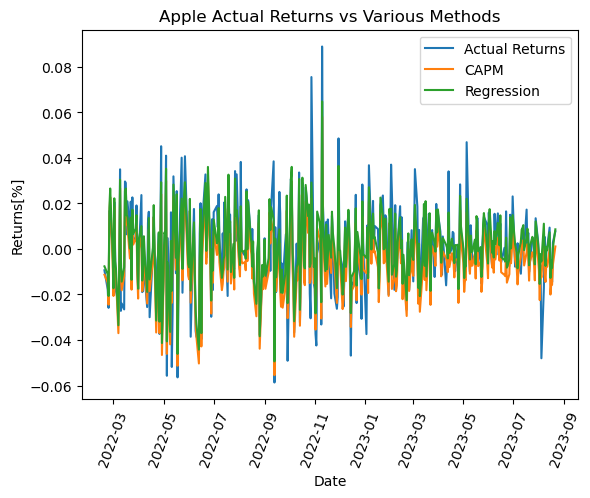

In [40]:
plt.plot(x, y1)
plt.plot(x, y2)
plt.plot(x, y3)
plt.xticks(rotation=70)
plt.title("Apple Actual Returns vs Various Methods")
plt.xlabel("Date")
plt.ylabel("Returns[%]")
plt.legend(["Actual Returns", "CAPM", "Regression"])
plt.show()

Now lets try to calculate the $R^2$ score for both methods:

In [41]:
r2_score(predicted_returns_by_method["actual returns"], predicted_returns_by_method["capm predicted returns"])

0.6537139833542245

In [42]:
r2_score(predicted_returns_by_method["actual returns"], predicted_returns_by_method["regression predicted returns"])

0.733580331966668

**In the case of Apple Linear Regression model is more accurate the CAPM**

### Repeating experiment for MSFT stocks

In [43]:
msft_predicted_returns, regression, msft_actual_returns = predic_returns(msft_daily_returns, sp500_daily_returns)
beta = regression.coef_

In [44]:
msft_cpam = predict_returns_capm("AAPL", beta, sp500, bond_interest_rates)

In [45]:
msft_cpam_returns = appl_cpam[["date", "capm predicted returns"]]

In [46]:
dates = msft.loc[apple_actual_returns.index]["date"]
predicted_returns_by_method = pd.DataFrame(
    {  "date": dates, "actual returns":msft_actual_returns, 
       "regression predicted returns":msft_predicted_returns, 
    })

In [47]:
predicted_returns_by_method = predicted_returns_by_method.merge(msft_cpam_returns, on="date")

In [48]:
predicted_returns_by_method

,date,actual returns,regression predicted returns,capm predicted returns
0,2022-02-18,-0.009631,-0.007906,-0.011332
1,2022-02-22,-0.000729,-0.011441,-0.014811
2,2022-02-23,-0.025893,-0.021262,-0.024465
3,2022-02-24,0.051094,0.018367,0.014223
4,2022-02-25,0.009233,0.027174,0.022795
...,...,...,...,...
372,2023-08-15,-0.006728,-0.013114,-0.020028
373,2023-08-16,-0.002428,-0.008368,-0.015511
374,2023-08-17,-0.010986,-0.008555,-0.015725
375,2023-08-18,-0.001262,0.000428,-0.006903


In [49]:
r2_score(predicted_returns_by_method["actual returns"], predicted_returns_by_method["capm predicted returns"])

0.5839293516454822

In [50]:
r2_score(predicted_returns_by_method["actual returns"], predicted_returns_by_method["regression predicted returns"])

0.665388184771174

**In the case of Apple Linear Regression model is more accurate the CAPM**

## Conclusion

The two experiments for MSFT and APPLE, indicate that our hypothesis may be wrong. The Linear Regression has higher $R^2$ score, than the CAPM, no matter we expected that the additional factor - interest rate, should add more information. Our expectation was that additional information could lead to higher accuracy. 

## Possible Actions

Two experiments are not enough to prove or disprove our hyputhesis. As a minimum we may repeat the experiment with multiple stocks in order to validate results.